# Lab | Sequence Modeling with LSTM

In [1]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers


embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size= 160000 #Your dataset size here. Experiment using smaller values (i.e. 16000), but don't forget to train on at least 160000 to see the best effects
test_portion=.1

corpus = []


In [2]:
#!wget --no-check-certificate \
   # https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    #-O /tmp/training_cleaned.csv

file_path = "training.1600000.processed.noemoticon.csv"
num_sentences = 0

with open(file_path, encoding='utf-8', errors='replace') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
      # Your Code here. Create list items where the first item is the text, found in row[5], and the second is the label. Note that the label is a '0' or a '4' in the text. When it's the former, make
      # your label to be 0, otherwise 1. Keep a count of the number of sentences in num_sentences
        # YOUR CODE HERE
        if len(row) >= 6:
          list_item=[]
          text = row[5]
          label = 0 if row[0] == '0' else 1
          list_item = [text, label]

          num_sentences = num_sentences + 1
          corpus.append(list_item)
        else:
            # Debug: Print a message when a row is skipped
            print(f"Skipping row due to insufficient columns: {row}")

# Print the results
print(f"Number of sentences: {num_sentences}")
print(f"Length of corpus: {len(corpus)}")
print(f"Corpus sample item: {corpus[1]}")


Number of sentences: 1600000
Length of corpus: 1600000
Corpus sample item: ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [3]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

# Expected Output:
# 1600000
# 1600000
# ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [23]:
#Create lists for sentences and labels
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])

#Tokenize
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

#Calculate vocabulary size
word_index = tokenizer.word_index
vocab_size=len(word_index)

max_length = 16

#Convert a list of texts into a list of sequences where each sequence is a list of integers
sequences = tokenizer.texts_to_sequences(sentences)
#Pad to ensure same length
padded = pad_sequences(sequences, maxlen=max_length, padding='post')

split = int(test_portion * training_size)

test_sequences = padded[:split]
training_sequences = padded[split:]
test_labels = labels[:split]
training_labels = labels[split:]

In [24]:
print(vocab_size)
print(word_index['i'])
# Expected Output
# 138858
# 1

138570
1


In [25]:
# Note this is the 100 dimension version of GloVe from Stanford
# I unzipped and hosted it on my site to make this notebook easier
#!wget --no-check-certificate \
#    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
#    -O /tmp/glove.6B.100d.txt
#embeddings_index = {};
with open('glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        if len(embedding_vector) == embedding_dim:
            embeddings_matrix[i] = embedding_vector

In [26]:
print(len(embeddings_matrix))
# Expected Output
# 138859

138571


In [31]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential

# Convert lists to numpy arrays
training_sequences = np.array(training_sequences)
training_labels = np.array(training_labels)
test_sequences = np.array(test_sequences)
test_labels = np.array(test_labels)


model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    # YOUR CODE HERE - experiment with combining different types, such as convolutions and LSTMs
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=4),
    Dropout(0.5),
    LSTM(units=64),
    Dropout(0.5),
    Dense(units=64, activation='relu'),
    Dense(units=1, activation='sigmoid')
])




In [35]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

num_epochs = 50

early_stop = EarlyStopping(
    monitor ='val_loss',
    patience = 10,
    verbose = 1,
    restore_best_weights = True
)

history = model.fit(training_sequences, training_labels, epochs=num_epochs, validation_data=(test_sequences, test_labels), callbacks = [early_stop], verbose=2)

print("Training Complete")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 16, 100)           13857100  
                                                                 
 conv1d_5 (Conv1D)           (None, 12, 128)           64128     
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 3, 128)            0         
 g1D)                                                            
                                                                 
 dropout (Dropout)           (None, 3, 128)            0         
                                                                 
 lstm_4 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                      

<Figure size 640x480 with 0 Axes>

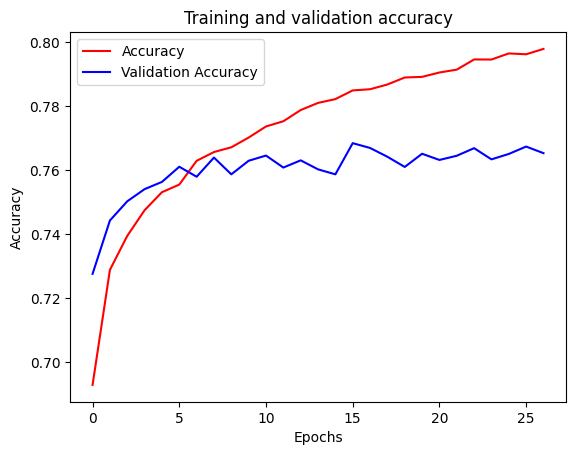

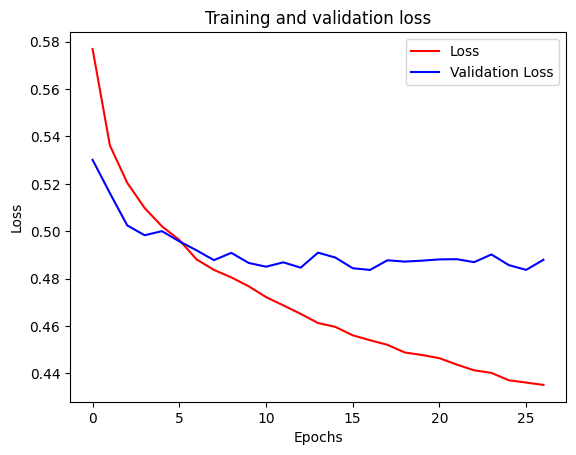

<Figure size 640x480 with 0 Axes>

In [36]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!